In [1]:
import os
import json
import subprocess
import tempfile

import numpy as np
from numpy.random import default_rng

from scipy.spatial import cKDTree
from scipy.stats import truncnorm

import pyvista as pv
import ogstools as ot
import porepy as pp

from pathlib import Path

from tqdm import tqdm
import imageio.v3 as iio

from IPython.display import Markdown, display, Image

import pyvista as pv
import numpy as np
from pathlib import Path
from scipy.spatial import cKDTree

In [2]:
def update_project_parameters(project: ot.Project, params: dict):
    update_map = {
        "prefix": ".//time_loop/output/prefix",
        "initial_pressure": ".//parameters/parameter[name='p0']/expression",
        "inlet_pressure": ".//parameters/parameter[name='p_left']/expression",
        "outlet_pressure": ".//parameters/parameter[name='p_right']/expression",
        "inlet_concentration_value": ".//parameters/parameter[name='c_bottom']/value",
        "porosity_value": ".//parameters/parameter[name='constant_porosity_parameter']/value",
        "permeability_value": ".//parameters/parameter[name='kappa1_frac']/values",
        "fracture_thickness_value": ".//parameters/parameter[name='fracture_thickness_const']/value",
        "decay_Si_value": ".//parameters/parameter[name='decay']/value",
        "t_end": ".//time_loop/processes/process/time_stepping/t_end",
        "initial_dt": ".//time_loop/processes/process/time_stepping/initial_dt",
        "minimum_dt": ".//time_loop/processes/process/time_stepping/minimum_dt",
        "maximum_dt": ".//time_loop/processes/process/time_stepping/maximum_dt",
        "specific_body_force": ".//processes/process/specific_body_force",
        "longitudinal_dispersivity_value": ".//media/medium/properties/property[name='longitudinal_dispersivity']/value",
        "transversal_dispersivity_value": ".//media/medium/properties/property[name='transversal_dispersivity']/value",
    }

    for key, xpath in update_map.items():
        if key in params:
            try:
                project.replace_text(params[key], xpath=xpath)
                display(Markdown(f"**Success:** Parameter `{key}` updated to **{params[key]}**"))
            except Exception as e:
                msg = f"Failed to update parameter `{key}`: {e}"
                display(Markdown(f"**Error:** {msg}"))
                raise RuntimeError(msg) from e

    # Permeability tensor update

    if "permeability_value" in params:
        try:
            xpath = ".//parameters/parameter[name='kappa1_frac']/values"
            project.replace_text(params["permeability_value"], xpath=xpath)
            display(Markdown("**Success:** Updated `kappa1_frac` permeability tensor."))
        except Exception as e:
            raise RuntimeError(f"Could not update permeability_value: {e}")


    # Fluid density
    density_xpath = ".//media/medium/phases/phase/properties/property[name='density']"
    existing_density = project.tree.find(density_xpath)

    if existing_density is None:
        density = params.get("fluid_density", {"type": "Constant", "value": "1e-3"})
        dtype = density.get("type")

        # Add <property><name>density</name> under phase properties
        project.add_element(".//media/medium/phases/phase[type='AqueousLiquid']/properties", "property")

        prop_xpath = ".//media/medium/phases/phase/properties/property[last()]"
        project.add_element(prop_xpath, "name", "density")

        if dtype == "Constant":
            project.add_element(prop_xpath, "type", "Constant")
            project.add_element(prop_xpath, "value", density.get("value", "1e-3"))
            display(Markdown("**Success:** Added default `Constant` fluid density under phase properties."))

        elif dtype == "Linear":
            project.add_element(prop_xpath, "type", "Linear")
            project.add_element(prop_xpath, "reference_value", density.get("reference_value", "1000"))
            iv_xpath = f"{prop_xpath}/independent_variable"
            project.add_element(prop_xpath, "independent_variable")
            project.add_element(iv_xpath, "variable_name", density.get("variable_name", "liquid_phase_pressure"))
            project.add_element(iv_xpath, "reference_condition", density.get("reference_condition", "1e5"))
            project.add_element(iv_xpath, "slope", density.get("slope", "4.5e-11"))
            display(Markdown("**Success:** Added `Linear` fluid density under phase properties."))

        else:
            raise ValueError("`fluid_density` must include a 'type' of either 'Constant' or 'Linear'")




    # Numerical Stabilization
    main_proc_xpath = "processes/process[1]"
    project.remove_element(f"{main_proc_xpath}/numerical_stabilization")

    if "numerical_stabilization" in params:
        stab = params["numerical_stabilization"]
        stype = stab.get("type")
        if not stype:
            raise ValueError("'type' is required in numerical_stabilization")

        project.add_element(main_proc_xpath, "numerical_stabilization")
        ns_xpath = f"{main_proc_xpath}/numerical_stabilization[last()]"
        project.add_element(ns_xpath, "type", stype)

        if stype == "FullUpwind":
            cutoff = stab.get("cutoff_velocity", "0.0")
            project.add_element(ns_xpath, "cutoff_velocity", cutoff)
        elif stype == "IsotropicDiffusion":
            tuning = stab.get("tuning_parameter")
            cutoff = stab.get("cutoff_velocity")
            if tuning is None or cutoff is None:
                raise ValueError("'tuning_parameter' and 'cutoff_velocity' required for IsotropicDiffusion")
            project.add_element(ns_xpath, "tuning_parameter", tuning)
            project.add_element(ns_xpath, "cutoff_velocity", cutoff)
        elif stype == "FluxCorrectedTransport":
            pass
        else:
            raise ValueError(f"Unsupported stabilization type: {stype}")

        display(Markdown(f"**Success:** Configured numerical stabilization in main processes with type `{stype}`"))


In [3]:
ot.plot.setup.show_Region_bounds = False

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)


mesh_rough_dir = out_dir / "mesh_rough"
mesh_rough_dir.mkdir(parents=True, exist_ok=True)

mesh_flattened_dir = out_dir / "mesh_flattened"
mesh_flattened_dir.mkdir(parents=True, exist_ok=True)


flattened_results_dir = out_dir / "flattened_results"
flattened_results_dir.mkdir(parents=True, exist_ok=True)

rough_results_dir = out_dir / "rough_results"
rough_results_dir.mkdir(parents=True, exist_ok=True)    

## Detrend surface-3D

**Level the original 3D mesh by subtracting a global best-fit plane (NumPy & PyVista).**
   Load the raw STL into PyVista (surf = pv.read(surface_file)) and extract its (x,y,z) vertices. Build a design matrix with rows [x_i, y_i, 1] and solve

   $$
     \min_{a,b,c}\sum_i\bigl(z_i - (a\,x_i + b\,y_i + c)\bigr)^2
   $$

   via NumPy’s np.linalg.lstsq. Subtracting $a\,x_i + b\,y_i + c$ from each original $z_i$ removes specimen-scale tilt so that all subsequent measurements reflect only the fracture’s intrinsic roughness.
   *Alternatives:* include quadratic terms $(x^2,xy,y^2)$ in the design matrix for a curved baseline, or use SciPy’s least_squares(loss='huber') / scikit-learn’s HuberRegressor to resist outliers.

In [4]:
surface_file    = "Basalt 2a1.stl"
grid_resolution = 200      # resolution of the 2D width map

surf = pv.read(surface_file)
pts  = surf.points
A    = np.c_[pts[:, 0], pts[:, 1], np.ones(len(pts))]
[a, b, c], *_ = np.linalg.lstsq(A, pts[:, 2], rcond=None)
z_plane_all    = a * pts[:, 0] + b * pts[:, 1] + c
z_detrended_all = pts[:, 2] - z_plane_all

detrended_all = surf.copy()
detrended_all.points = np.column_stack((pts[:, 0], pts[:, 1], z_detrended_all))
ugrid = detrended_all.cast_to_unstructured_grid()
ugrid.save(f"{mesh_rough_dir}/detrended_surface.vtu")
print("Saved detrended surface as UnstructuredGrid: detrended_surface.vtu")
plotter_init = pv.Plotter(shape=(1, 2), window_size=(1200, 600))
plotter_init.subplot(0, 0)
plotter_init.add_text("Original fracture surface (raw data)", font_size=14)
plotter_init.add_mesh(surf, color="lightgray", show_edges=False)
plotter_init.add_axes()
plotter_init.camera_position = "iso"
plotter_init.subplot(0, 1)
plotter_init.add_text("Detrended surface profile", font_size=14)
plotter_init.add_mesh(
    detrended_all,
    scalars=z_detrended_all,
    cmap="viridis",
    clim=[z_detrended_all.min(), z_detrended_all.max()],
    show_edges=False,
    smooth_shading=True,
    show_scalar_bar=False
)
plotter_init.add_axes()
plotter_init.add_scalar_bar(title="Z", vertical=True)
plotter_init.link_views()
plotter_init.show()


Saved detrended surface as UnstructuredGrid: detrended_surface.vtu


Widget(value='<iframe src="http://localhost:51104/index.html?ui=P_0x105168440_0&reconnect=auto" class="pyvista…

## Method1: Extract fracture surface from 3D box

 **Compute per-triangle normals and select upward-facing facets (PyVista).**
   Invoke surf.compute_normals(cell_normals=True) to generate one normal vector per triangular element. For each triangle, require its normal’s vertical component $n_z$ to satisfy

   $$
     n_z \;\ge\;\cos(80^\circ),
   $$

   thereby retaining only facets tilted at most 80° from true vertical. This step discards side walls and undercuts, isolating the raw top-surface elements.

 **Extract the single continuous top-surface patch by element connectivity (PyVista).**
   Call extract_cells(...) on the orientation-filtered mesh and then .connectivity(largest=True). PyVista builds an element-connectivity graph—linking two triangles if they share the same two vertices—and identifies all connected components. It keeps only the component with the greatest number of elements, automatically discarding any isolated debris and yielding one uninterrupted top-surface mesh.

 **Remove residual slope on the extracted top surface with a local plane fit (NumPy).**
   Even after global leveling, the extracted patch can retain slight planar bias. Extract its (x,y,z) points and again solve

   $$
     \min_{a',b',c'}\sum_i\bigl(z_i - (a'\,x_i + b'\,y_i + c')\bigr)^2
   $$

   via np.linalg.lstsq. Subtract $a'\,x_i + b'\,y_i + c'$ from each patch point’s $z_i$, producing a zero-mean width field that captures only micro-scale roughness.

  **Rasterize the detrended top surface into a regular 2D widthtmap (SciPy & NumPy).**
   We first build a SciPy cKDTree on the patch’s $(x,y)$ coordinates—this is a binary spatial index that lets us quickly find the nearest neighbour for any query point. Next, we define a uniform $N\times N$ mesh over the bounding rectangle $[x_{\min},x_{\max}]\times[y_{\min},y_{\max}]$ using np.linspace and np.meshgrid. For each grid node $(x_j,y_k)$, we perform a **nearest-neighbour query** (tree.query) to locate the closest original patch point and retrieve its detrended width. The result is a complete, evenly spaced 2D array of widths, ready for quantitative roughness analysis.

  **Export a flat VTK grid of roughness widths (PyVista).**
Build a StructuredGrid(xx, yy, 0), attach the width array as a scalar field, and save via grid2d.save("fracture_top_widthmap.vtu").

In [5]:
angle_thresh    = 85.    # degrees from vertical for top-surface selection

surf = pv.read(surface_file)
surf = surf.compute_normals(cell_normals=True, point_normals=False)

mask = surf.cell_data["Normals"][:, 2] >= np.cos(np.deg2rad(angle_thresh))
top_surface = surf.extract_cells(np.where(mask)[0]).connectivity(largest=True)
top_surface.save(f"{mesh_rough_dir}/fracture_top_raw.vtu")
print("Saved raw top surface: fracture_top_raw.vtu")

pts_top = top_surface.points
A_top   = np.c_[pts_top[:, 0], pts_top[:, 1], np.ones(len(pts_top))]
[a_top, b_top, c_top], *_ = np.linalg.lstsq(A_top, pts_top[:, 2], rcond=None)
z_plane = a_top * pts_top[:, 0] + b_top * pts_top[:, 1] + c_top
z_detrended_top = pts_top[:, 2] - z_plane

detrended_top = top_surface.copy()
detrended_top.points[:, 2] = z_detrended_top
detrended_top.point_data["z_detrended_top"] = z_detrended_top

for mesh in [top_surface, detrended_top]:
    if "RegionId" in mesh.cell_data:
        del mesh.cell_data["RegionId"]
    if "RegionId" in mesh.point_data:
        del mesh.point_data["RegionId"]

detrended_top.save(f"{mesh_rough_dir}/fracture_top_detrended.vtu")
print("Saved detrended top surface: fracture_top_detrended.vtu")

xy_src = pts_top[:, :2]
tree   = cKDTree(xy_src)

xmin, xmax = xy_src[:, 0].min(), xy_src[:, 0].max()
ymin, ymax = xy_src[:, 1].min(), xy_src[:, 1].max()

x = np.linspace(xmin, xmax, grid_resolution)
y = np.linspace(ymin, ymax, grid_resolution)
xx, yy = np.meshgrid(x, y)
xy_query = np.column_stack([xx.ravel(), yy.ravel()])
_, idx_nn = tree.query(xy_query)
width    = z_detrended_top[idx_nn]
zz_flat = np.zeros_like(xx)
grid2d  = pv.StructuredGrid(xx.T, yy.T, zz_flat.T)
grid2d.point_data["width"] = width
grid2d.save(f"{mesh_rough_dir}/fracture_top_widthmap.vtk")
print("Saved flat width map: fracture_top_widthmap.vtk")

/Volumes/OpenGeoSys/build/release/.venv/lib/python3.13/site-packages/pyvista/core/filters/data_set.py:1963: PyVistaDeprecationWarning: Use of `largest=True` is deprecated. Use 'largest' or `extraction_mode='largest'` instead.
  warnings.warn(
2025-06-18 17:23:24.094 (   5.137s) [           24931]       vtkXMLWriter.cxx:1157  WARN| vtkXMLUnstructuredGridWriter (0x335504310): Using legacy vtkDataArray API, which may result in precision loss
2025-06-18 17:23:24.624 (   5.666s) [           24931]       vtkXMLWriter.cxx:1157  WARN| vtkXMLUnstructuredGridWriter (0x335504310): Using legacy vtkDataArray API, which may result in precision loss


Saved raw top surface: fracture_top_raw.vtu
Saved detrended top surface: fracture_top_detrended.vtu
Saved flat width map: fracture_top_widthmap.vtk


In [6]:
# pv.set_jupyter_backend('static')   # Render inline as a PNG
PLOTTER_WIDTH  = 1200              
PLOTTER_HEIGHT = 500               

vmin_comb = z_detrended_top.min()
vmax_comb = z_detrended_top.max()

plotter_combined = pv.Plotter(
    shape=(1, 3),
    window_size=(PLOTTER_WIDTH, PLOTTER_HEIGHT),
    notebook=True
)

plotter_combined.subplot(0, 0)
plotter_combined.add_text("Raw top surface", font_size=12)
plotter_combined.add_mesh(top_surface, color="lightgray", show_edges=False)
plotter_combined.add_axes()

plotter_combined.subplot(0, 1)
plotter_combined.add_text("Detrended top surface", font_size=12)
plotter_combined.add_mesh(
    detrended_top,
    scalars="z_detrended_top",
    cmap="turbo",
    clim=[vmin_comb, vmax_comb],
    smooth_shading=True,
    show_edges=False,
    show_scalar_bar=False
)
plotter_combined.add_axes()
plotter_combined.add_scalar_bar(title="Z − plane", vertical=True)

plotter_combined.subplot(0, 2)
plotter_combined.add_text("Flat width Mapped", font_size=12)
plotter_combined.enable_parallel_projection()
plotter_combined.view_xy()
plotter_combined.camera.up = (0, 0, 0)
plotter_combined.add_mesh(
    grid2d,
    scalars="width",
    cmap="turbo",
    clim=[vmin_comb, vmax_comb],
    show_edges=False,
    show_scalar_bar=False
)
plotter_combined.add_axes()
plotter_combined.add_scalar_bar(title="width", vertical=True)
plotter_combined.link_views()

plotter_combined.show(
    # jupyter_kwargs={'width': PLOTTER_WIDTH, 'height': PLOTTER_HEIGHT},
    auto_close=False
)

Widget(value='<iframe src="http://localhost:51104/index.html?ui=P_0x157faa210_1&reconnect=auto" class="pyvista…

## Method2: Extract fracture surface from 3D box by cutting the boundaries

In [7]:
def run_command(cmd, description=""):
    try:
        subprocess.run(cmd, check=True)
        print(f"{description} done.")
    except subprocess.CalledProcessError as e:
        print(f"Failed: {description}")
        print(f"Command: {' '.join(cmd)}")
        print(f"Error: {e}")
        raise

mesh = pv.read(f"{mesh_rough_dir}/detrended_surface.vtu")
bounds = mesh.bounds

print(f"  X: {bounds[0]:.3f} to {bounds[1]:.3f}")
print(f"  Y: {bounds[2]:.3f} to {bounds[3]:.3f}")
print(f"  Z: {bounds[4]:.3f} to {bounds[5]:.3f}")

points = mesh.points
x_min = np.percentile(points[:, 0], 10)
x_max = np.percentile(points[:, 0], 99) # ─── CLIP TO RECTANGLE (10–99% range) 

y_min, y_max = np.percentile(points[:, 1], [7.5, 92.5])
z_max = points[:, 2].max()
z_min = z_max - 0.5 * (z_max - mesh.bounds[4])

clipped = mesh.clip_box(bounds=(x_min, x_max, y_min, y_max, z_min, z_max), invert=False)

clipped_surface = clipped.extract_surface()
clipped_smooth = clipped_surface.smooth(n_iter=100)

#FILL HOLES 
try:
    filled_surface = clipped_smooth.fill_holes(5.0)  # units hole size
    print("Holes filled on PolyData surface.")
except Exception as e:
    print("Could not fill holes:", e)
    filled_surface = clipped_smooth  

ugrid = filled_surface.cast_to_unstructured_grid()
ugrid.save(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")
print("Saved final mesh as 'fracture_top_rectangular.vtu")

  X: -85.006 to 63.165
  Y: -84.056 to 70.788
  Z: -55.780 to 20.394
Holes filled on PolyData surface.
Saved final mesh as 'fracture_top_rectangular.vtu


## Use the Coarser the meshes

In [8]:
target_reduction = 0.90  # Reduce mesh by 90%
coarse_mesh = filled_surface.decimate(target_reduction=target_reduction)
coarse_ugrid = coarse_mesh.cast_to_unstructured_grid()
coarse_ugrid.save(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")
print("Saved simplified detrended surface: fracture_top_rectangular.vtu")

Saved simplified detrended surface: fracture_top_rectangular.vtu


## Change the origin, scale  mm → m of mesh

In [9]:
mesh = pv.read(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")

points_m = mesh.points * 0.001 # mm → m

# Shift X and Y so lower-left becomes (0, 0),  Shift Z so Z-min becomes 0
x_shift = np.min(points_m[:, 0])
y_shift = np.min(points_m[:, 1])
points_m[:, 0] -= x_shift
points_m[:, 1] -= y_shift
z_shift = np.min(points_m[:, 2])
points_m[:, 2] -= z_shift
mesh.points = points_m

print("New mesh bounds (in meters):")
print(f"  X: {mesh.bounds[0]:.3f} to {mesh.bounds[1]:.3f}")
print(f"  Y: {mesh.bounds[2]:.3f} to {mesh.bounds[3]:.3f}")
print(f"  Z: {mesh.bounds[4]:.3f} to {mesh.bounds[5]:.3f}")

mesh.save(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")
print("Mesh scaled to meters and shifted.")

New mesh bounds (in meters):
  X: 0.000 to 0.130
  Y: 0.000 to 0.131
  Z: 0.000 to 0.015
Mesh scaled to meters and shifted.


## Add fractography of fracture as mesh properties

In [10]:
mesh = pv.read(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")
pts = mesh.points

original_z_min = pts[:, 2].min()
original_z_max = pts[:, 2].max()
original_z_range = abs(original_z_max - original_z_min)

A = np.c_[pts[:, 0], pts[:, 1], np.ones(len(pts))]
[a, b, c], *_ = np.linalg.lstsq(A, pts[:, 2], rcond=None)
z_plane = a * pts[:, 0] + b * pts[:, 1] + c
z_detrended = pts[:, 2] - z_plane

z_detrended_shifted = z_detrended - z_detrended.min()  # make min zero
z_detrended_shifted *= (original_z_range / z_detrended_shifted.max())  # stretch to match original range

mesh.point_data["z_detrended_shifted"] = z_detrended_shifted
mesh.save(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")

print("Detrended Z shifted and scaled to match original Z range.")
print(f"Final range: {z_detrended_shifted.min():.5f} to {z_detrended_shifted.max():.5f} meters")

Detrended Z shifted and scaled to match original Z range.
Final range: 0.00000 to 0.01542 meters


# Rough fracture 

### Preparation of meshes and boundaries for run simulation in OpenGeoSys

In [11]:
# Add MaterialIDs = 0 to all cells
mesh = pv.read(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")
material_ids = np.zeros(mesh.n_cells, dtype=np.int32)
mesh.cell_data.clear()  
mesh.cell_data.set_array(material_ids, "MaterialIDs")
mesh.save(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")
print("MaterialIDs set on cells and mesh saved.")


def run_command(cmd, description=""):
    try:
        subprocess.run(cmd, check=True)
        print(f"{description} done.")
    except subprocess.CalledProcessError as e:
        print(f"Failed: {description}")
        print(f"Command: {' '.join(cmd)}")
        print(f"Error: {e}")
        raise

        
orig_dir = Path.cwd()
%cd {mesh_rough_dir}

mesh = pv.read("fracture_top_rectangular.vtu")
bounds = mesh.bounds 

x_min, x_max = bounds[0], bounds[1]
y_min, y_max = bounds[2], bounds[3]

domain_size = max(x_max - x_min, y_max - y_min)
boundary_tol_fraction = 1e-4
boundary_tol = boundary_tol_fraction * domain_size

x_left   = x_min + boundary_tol
x_right  = x_max - boundary_tol
y_bottom = y_min + boundary_tol
y_top    = y_max - boundary_tol

# ─── FILE PATHS ─────────────────────────────────────────────────────────────
original_file   = "fracture_top_rectangular.vtu"
boundary_file   = "boundaries.vtu"

# ─── 0. REORDER NODES OF MAIN MESH ──────────────────────────────────────────
run_command([
    "NodeReordering",
    "-i", original_file,
    "-o", original_file,
    "-m", "1"
], description="Reorder nodes in main mesh")

# ─── 2. EXTRACT ALL BOUNDARIES ──────────────────────────────────────────────
run_command([
    "ExtractBoundary",
    "-i", original_file,
    "-o", boundary_file
], description="Extract boundary surface")

# ─── 3. LEFT (X ≈ min) ──────────────────────────────────────────────────────
x_left_max = x_left + boundary_tol
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "left.vtu",
    "--x-min", str(x_left_max)
], description="Extract left boundary")

# ─── 4. RIGHT (X ≈ max) ─────────────────────────────────────────────────────
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "right.vtu",
    "--x-max", str(x_right)
], description="Extract right boundary")

# ─── 5. BOTTOM (Y ≈ min) ────────────────────────────────────────────────────
y_bottom_max = y_bottom + boundary_tol
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "bottom.vtu",
    "--y-min", str(y_bottom_max)
], description="Extract bottom boundary")

# ─── 6. TOP (Y ≈ max) ───────────────────────────────────────────────────────
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "top.vtu",
    "--y-max", str(y_top)
], description="Extract top boundary")

# ─── 7. IDENTIFY SUBDOMAINS FOR ALL BOUNDARIES ──────────────────────────────
boundary_parts = ["left.vtu", "right.vtu", "bottom.vtu", "top.vtu"]
run_command([
    "identifySubdomains",
    "-m", original_file,
    *boundary_parts
], description="Map bulk_node_ids and bulk_element_ids to boundaries")

# ─── 8.  MESH CHECK ────────────────────────────────────────────────────
run_command([
    "checkMesh",
    "-v",
    "-p",
    original_file
], description="Final mesh validation check")

%cd $orig_dir

MaterialIDs set on cells and mesh saved.
/Volumes/Projects/RiskXclude/VL700/_out/mesh_rough
[2025-06-18 17:23:32.840] [ogs] [info] Reordering nodes... 
[2025-06-18 17:23:32.840] [ogs] [info] Corrected 57 elements.
[2025-06-18 17:23:32.861] [ogs] [info] VTU file written.
Reorder nodes in main mesh done.
[2025-06-18 17:23:32.975] [ogs] [info] Mesh read: 36350 nodes, 72232 elements.
[2025-06-18 17:23:32.976] [ogs] [info] 2 property vectors copied, 0 vectors skipped.
[2025-06-18 17:23:32.976] [ogs] [info] Created surface mesh: 466 nodes, 466 elements.
Extract boundary surface done.
[2025-06-18 17:23:33.039] [ogs] [info] Mesh read: 466 nodes, 466 elements.
[2025-06-18 17:23:33.039] [ogs] [info] Bounding box of "boundaries" is
x = [0.000000,0.130355]
y = [0.000000,0.130600]
z = [0.001184,0.013729]
[2025-06-18 17:23:33.039] [ogs] [info] 323 elements found.
[2025-06-18 17:23:33.039] [ogs] [info] Removing total 323 elements...
[2025-06-18 17:23:33.039] [ogs] [info] 143 elements remain in mesh.


## Plot meshes

In [12]:
# pv.set_jupyter_backend('static')    # or 'panel', 'ipygany' 

plotter = pv.Plotter()
plotter.add_mesh(mesh, color="lightgray", opacity=0.2)

colors = {"left": "blue", "right": "red", "bottom": "green", "top": "orange"}
for name, color in colors.items():
    part = pv.read(mesh_rough_dir / f"{name}.vtu")
    plotter.add_mesh(part, color=color, line_width=4, label=name.upper(), render_lines_as_tubes=True)

plotter.add_legend()
plotter.show_axes()
plotter.view_isometric()
plotter.show()

Widget(value='<iframe src="http://localhost:51104/index.html?ui=P_0x17fad3110_2&reconnect=auto" class="pyvista…

## Project file preparation

In [13]:
user_parameters_rough = {
    "prefix": "roughFracture_HC",
    "t_end": "1.e3",
    "initial_dt": ".001",
    "minimum_dt": ".001",
    "maximum_dt": "100",
    "specific_body_force": "0 0 -9.81",
    "longitudinal_dispersivity_value": "1",
    "transversal_dispersivity_value": "0.1",
    "initial_pressure": "1000*9.81*(z-0.015) + 1e5",
    "outlet_pressure": "1000*9.81*(z-0.015) + 1e5",
    "inlet_pressure": "1000*9.81*(z-0.015) + 5e5",
    "inlet_concentration_value": "1",
    "porosity_value": "0.005",
    "permeability_value": """1e-19 0 0\n0 1e-19 0\n0 0 1e-19""",
    "decay_Si_value": "1e-7",
    "numerical_stabilization": {
        "type": "FluxCorrectedTransport",
    },
    "fluid_density": {
        "type": "Linear",
        "reference_value": "1000",
        "variable_name": "liquid_phase_pressure",
        "reference_condition": "1e5",
        "slope": "4.5e-11"
    }
}

project_file = Path("roughFracture_HC.prj")
project = ot.Project(
    input_file=project_file, output_file=Path(f"{out_dir}/roughFracture_HC_final.prj")
)
update_project_parameters(project, user_parameters_rough)
project.write_input()

**Success:** Parameter `prefix` updated to **roughFracture_HC**

**Success:** Parameter `initial_pressure` updated to **1000*9.81*(z-0.015) + 1e5**

**Success:** Parameter `inlet_pressure` updated to **1000*9.81*(z-0.015) + 5e5**

**Success:** Parameter `outlet_pressure` updated to **1000*9.81*(z-0.015) + 1e5**

**Success:** Parameter `inlet_concentration_value` updated to **1**

**Success:** Parameter `porosity_value` updated to **0.005**

**Success:** Parameter `permeability_value` updated to **1e-19 0 0
0 1e-19 0
0 0 1e-19**

**Success:** Parameter `decay_Si_value` updated to **1e-7**

**Success:** Parameter `t_end` updated to **1.e3**

**Success:** Parameter `initial_dt` updated to **.001**

**Success:** Parameter `minimum_dt` updated to **.001**

**Success:** Parameter `maximum_dt` updated to **100**

**Success:** Parameter `specific_body_force` updated to **0 0 -9.81**

**Success:** Parameter `longitudinal_dispersivity_value` updated to **1**

**Success:** Parameter `transversal_dispersivity_value` updated to **0.1**

**Success:** Updated `kappa1_frac` permeability tensor.

**Success:** Added `Linear` fluid density under phase properties.

**Success:** Configured numerical stabilization in main processes with type `FluxCorrectedTransport`

## Run the simulation

In [14]:
project.run_model(args=f"-o {rough_results_dir} -m {mesh_rough_dir}", logfile=Path(mesh_rough_dir, "run.log"))

Project file written to output.
Simulation: _out/roughFracture_HC_final.prj
Status: finished successfully.
Execution took 187.3844449520111 s


## Plot results

In [15]:
base_scalar_bar_args = {
    "vertical": True,
    "position_x": 0.9,
    "position_y": 0.2,
    "width": 0.03,
    "height": 0.6,
    "title_font_size": 20,
    "label_font_size": 16,
    "n_labels": 4,
    "color": "black",
    "fmt": "%.1f",
}

# Flattened fracture

In [16]:
mesh = pv.read(f"{mesh_rough_dir}/fracture_top_rectangular.vtu")
points = mesh.points.copy()

A = np.c_[points[:, 0], points[:, 1], np.ones(points.shape[0])]
coeffs, *_ = np.linalg.lstsq(A, points[:, 2], rcond=None)
a, b, c = coeffs
z_fitted = a * points[:, 0] + b * points[:, 1] + c  

points[:, 0] -= np.min(points[:, 0])  # shift X origin to 0
points[:, 1] -= np.min(points[:, 1])  # shift Y origin to 0

x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
x_range = x_max - x_min
tol = 1e-6

z_fit_xmin = np.mean(z_fitted[np.abs(points[:, 0] - x_min) < tol])
z_fit_xmax = np.mean(z_fitted[np.abs(points[:, 0] - x_max) < tol])

z_target_xmin = np.mean(mesh.points[np.abs(points[:, 0] - x_min) < tol][:, 2])
z_target_xmax = np.mean(mesh.points[np.abs(points[:, 0] - x_max) < tol][:, 2])

z_rescaled = (z_fitted - z_fit_xmin) / (z_fit_xmax - z_fit_xmin)
z_aligned = z_target_xmin + z_rescaled * (z_target_xmax - z_target_xmin)
z_shifted = z_aligned - np.min(z_aligned)  # shift to min=0



points[:, 2] = z_aligned
mesh.points = points
mesh.point_data["z_detrended"] = mesh.points[:, 2] - z_fitted  

bounds = mesh.bounds
nx, ny = 100, 100
x = np.linspace(bounds[0], bounds[1], nx)
y = np.linspace(bounds[2], bounds[3], ny)
xx, yy = np.meshgrid(x, y, indexing='ij')
zz = a * xx + b * yy + c

z_fit_struct = (zz - z_fit_xmin) / (z_fit_xmax - z_fit_xmin)
zz_rescaled = z_target_xmin + z_fit_struct * (z_target_xmax - z_target_xmin)
zz_shifted = zz_rescaled - np.min(zz_rescaled)

structured = pv.StructuredGrid(xx, yy, zz_rescaled)
triangulated = structured.extract_surface().triangulate()
coarse_mesh_vtu = triangulated.cast_to_unstructured_grid()

coarse_mesh_vtu = coarse_mesh_vtu.interpolate(mesh, radius=1e-3, sharpness=2)

if "MaterialIDs" in mesh.cell_data:
    orig_centers = mesh.cell_centers().points
    new_centers = coarse_mesh_vtu.cell_centers().points
    tree = cKDTree(orig_centers)
    _, idx = tree.query(new_centers)
    coarse_mesh_vtu.cell_data["MaterialIDs"] = mesh.cell_data["MaterialIDs"][idx]


output_path = mesh_flattened_dir / "fracture_top_rectangular.vtu"
coarse_mesh_vtu.save(output_path)

print("Best-fit inclined surface aligned and saved.")
print(f"File: {output_path}")
print(f"Bounds: X {coarse_mesh_vtu.bounds[0]:.2f}–{coarse_mesh_vtu.bounds[1]:.2f}, "
      f"Y {coarse_mesh_vtu.bounds[2]:.2f}–{coarse_mesh_vtu.bounds[3]:.2f}, "
      f"Z {coarse_mesh_vtu.bounds[4]:.6f}–{coarse_mesh_vtu.bounds[5]:.6f}")


Best-fit inclined surface aligned and saved.
File: _out/mesh_flattened/fracture_top_rectangular.vtu
Bounds: X 0.00–0.13, Y 0.00–0.13, Z 0.003526–0.011613


In [17]:
orig_dir = Path.cwd()
%cd {mesh_flattened_dir}

mesh = pv.read("fracture_top_rectangular.vtu")
bounds = mesh.bounds  # [xmin, xmax, ymin, ymax, zmin, zmax]

x_min, x_max = bounds[0], bounds[1]
y_min, y_max = bounds[2], bounds[3]

domain_size = max(x_max - x_min, y_max - y_min)
boundary_tol_fraction = 1e-4
boundary_tol = boundary_tol_fraction * domain_size

x_left   = x_min + boundary_tol
x_right  = x_max - boundary_tol
y_bottom = y_min + boundary_tol
y_top    = y_max - boundary_tol

original_file   = "fracture_top_rectangular.vtu"
boundary_file   = "boundaries.vtu"

# ─── 0. REORDER NODES OF MAIN MESH ──────────────────────────────────────────
run_command([
    "NodeReordering",
    "-i", original_file,
    "-o", original_file,
    "-m", "1"
], description="Reorder nodes in main mesh")


# ─── 2. EXTRACT ALL BOUNDARIES ──────────────────────────────────────────────
run_command([
    "ExtractBoundary",
    "-i", original_file,
    "-o", boundary_file
], description="Extract boundary surface")

# ─── 3. LEFT (X ≈ min) ──────────────────────────────────────────────────────
x_left_max = x_left + boundary_tol
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "left.vtu",
    "--x-min", str(x_left_max)
], description="Extract left boundary")

# ─── 4. RIGHT (X ≈ max) ─────────────────────────────────────────────────────
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "right.vtu",
    "--x-max", str(x_right)
], description="Extract right boundary")

# ─── 5. BOTTOM (Y ≈ min) ────────────────────────────────────────────────────
y_bottom_max = y_bottom + boundary_tol
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "bottom.vtu",
    "--y-min", str(y_bottom_max)
], description="Extract bottom boundary")

# ─── 6. TOP (Y ≈ max) ───────────────────────────────────────────────────────
run_command([
    "removeMeshElements",
    "-i", boundary_file,
    "-o", "top.vtu",
    "--y-max", str(y_top)
], description="Extract top boundary")

# ─── 7. IDENTIFY SUBDOMAINS FOR ALL BOUNDARIES ──────────────────────────────
boundary_parts = ["left.vtu", "right.vtu", "bottom.vtu", "top.vtu"]
run_command([
    "identifySubdomains",
    "-m", original_file,
    *boundary_parts
], description="Map bulk_node_ids and bulk_element_ids to boundaries")

# ─── 8. FINAL MESH CHECK ────────────────────────────────────────────────────
run_command([
    "checkMesh",
    "-v",
    "-p",
    original_file
], description="Final mesh validation check")

%cd $orig_dir

/Volumes/Projects/RiskXclude/VL700/_out/mesh_flattened
[2025-06-18 17:26:41.060] [ogs] [info] Reordering nodes... 
[2025-06-18 17:26:41.060] [ogs] [info] Corrected 0 elements.
[2025-06-18 17:26:41.068] [ogs] [info] VTU file written.
Reorder nodes in main mesh done.
[2025-06-18 17:26:41.122] [ogs] [info] Mesh read: 10000 nodes, 19602 elements.
[2025-06-18 17:26:41.123] [ogs] [info] 5 property vectors copied, 0 vectors skipped.
[2025-06-18 17:26:41.123] [ogs] [info] Created surface mesh: 396 nodes, 396 elements.
Extract boundary surface done.
[2025-06-18 17:26:41.167] [ogs] [info] Mesh read: 396 nodes, 396 elements.
[2025-06-18 17:26:41.167] [ogs] [info] Bounding box of "boundaries" is
x = [0.000000,0.130355]
y = [0.000000,0.130600]
z = [0.003526,0.011613]
[2025-06-18 17:26:41.167] [ogs] [info] 297 elements found.
[2025-06-18 17:26:41.167] [ogs] [info] Removing total 297 elements...
[2025-06-18 17:26:41.167] [ogs] [info] 99 elements remain in mesh.
[2025-06-18 17:26:41.167] [ogs] [info] 

In [18]:
user_parameters_flattened = {
    "prefix": "flattenedFracture_HC",
    "t_end": "1.e3",
    "initial_dt": ".001",
    "minimum_dt": ".001",
    "maximum_dt": "100",
    "specific_body_force": "0 0 -9.81",
    "longitudinal_dispersivity_value": "1",
    "transversal_dispersivity_value": "0.1",
    "initial_pressure": "1000*9.81*(z-0.015) + 1e5",
    "outlet_pressure": "1000*9.81*(z-0.015) + 1e5",
    "inlet_pressure": "1000*9.81*(z-0.015) + 5e5",
    "inlet_concentration_value": "1",
    "porosity_value": "0.005",
    "permeability_value": """1e-19 0 0\n0 1e-19 0\n0 0 1e-19""",
    "decay_Si_value": "1e-7",
    "numerical_stabilization": {
        "type": "FluxCorrectedTransport",
    },
    "fluid_density": {
        "type": "Linear",
        "reference_value": "1000",
        "variable_name": "liquid_phase_pressure",
        "reference_condition": "1e5",
        "slope": "4.5e-11"
    }
}


project_file = Path("roughFracture_HC.prj")
project = ot.Project(
    input_file=project_file, output_file=Path(f"{out_dir}/flattenedFracture_HC_final.prj")
)
update_project_parameters(project, user_parameters_flattened)
project.write_input()

project.run_model(args=f"-o {flattened_results_dir} -m {mesh_flattened_dir}", logfile=Path(flattened_results_dir, "run_flattend.log"))

**Success:** Parameter `prefix` updated to **flattenedFracture_HC**

**Success:** Parameter `initial_pressure` updated to **1000*9.81*(z-0.015) + 1e5**

**Success:** Parameter `inlet_pressure` updated to **1000*9.81*(z-0.015) + 5e5**

**Success:** Parameter `outlet_pressure` updated to **1000*9.81*(z-0.015) + 1e5**

**Success:** Parameter `inlet_concentration_value` updated to **1**

**Success:** Parameter `porosity_value` updated to **0.005**

**Success:** Parameter `permeability_value` updated to **1e-19 0 0
0 1e-19 0
0 0 1e-19**

**Success:** Parameter `decay_Si_value` updated to **1e-7**

**Success:** Parameter `t_end` updated to **1.e3**

**Success:** Parameter `initial_dt` updated to **.001**

**Success:** Parameter `minimum_dt` updated to **.001**

**Success:** Parameter `maximum_dt` updated to **100**

**Success:** Parameter `specific_body_force` updated to **0 0 -9.81**

**Success:** Parameter `longitudinal_dispersivity_value` updated to **1**

**Success:** Parameter `transversal_dispersivity_value` updated to **0.1**

**Success:** Updated `kappa1_frac` permeability tensor.

**Success:** Added `Linear` fluid density under phase properties.

**Success:** Configured numerical stabilization in main processes with type `FluxCorrectedTransport`

Project file written to output.
Simulation: _out/flattenedFracture_HC_final.prj
Status: finished successfully.
Execution took 31.456442832946777 s


# Plots

Rendering comparison frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:05<00:00,  7.26it/s]


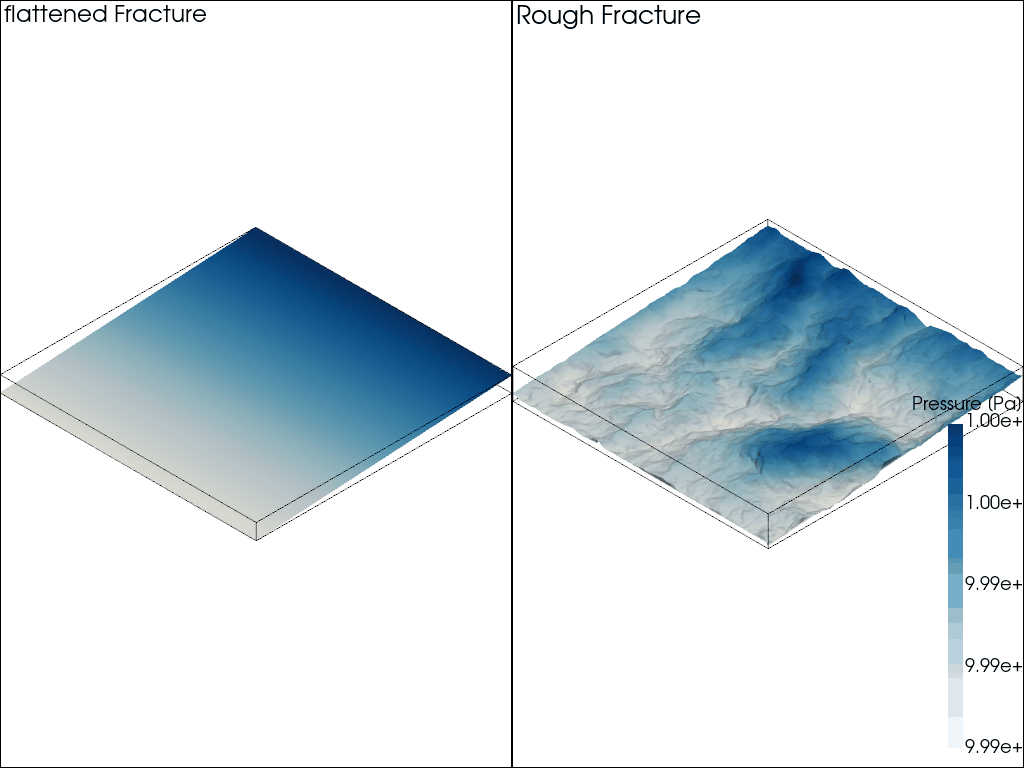

In [19]:
flattened_prefix = user_parameters_flattened["prefix"]
rough_prefix = user_parameters_rough["prefix"]
flattened_series = ot.MeshSeries(f"{flattened_results_dir}/{flattened_prefix}.pvd")
rough_series = ot.MeshSeries(f"{rough_results_dir}/{rough_prefix}.pvd")

frame_paths = []
n_frames = min(len(flattened_series), len(rough_series))
frame_dir = Path(out_dir) / "frames"
frame_dir.mkdir(parents=True, exist_ok=True)
for i in tqdm(range(n_frames), desc="Rendering comparison frames"):
    flattened_mesh = flattened_series[i]
    rough_mesh = rough_series[i]

    plotter = pv.Plotter(off_screen=True, shape=(1, 2), border=True)

    # ─── Flat Fracture View ───────────────────────────────────────────────
    plotter.subplot(0, 0)
    plotter.add_text("flattened Fracture", font_size=12)
    plotter.add_mesh(
        flattened_mesh,
        scalars="pressure",
        cmap="Blues",
        show_edges=False,
        opacity=1.0,
        show_scalar_bar=False,  
    )
    plotter.add_mesh(flattened_mesh.outline(), color="black", line_width=1)
    plotter.view_isometric()
    plotter.enable_parallel_projection()
    
    # ─── Rough Fracture View ──────────────────────────────────────────────
    plotter.subplot(0, 1)
    plotter.add_text("Rough Fracture", font_size=12)
    plotter.add_mesh(
        rough_mesh,
        scalars="pressure",
        cmap="Blues",
        show_edges=False,
        opacity=1.0,
        scalar_bar_args={
            "title": "Pressure [Pa]",
            "vertical": True,        
            "position_x": 0.85,      
        },
        show_scalar_bar=True,       
    )
    plotter.add_mesh(rough_mesh.outline(), color="black", line_width=1)
    plotter.view_isometric()
    plotter.enable_parallel_projection()

    frame_file = frame_dir / f"frame_comparison_{i:04d}.png"
    plotter.screenshot(str(frame_file))
    plotter.close()
    frame_paths.append(frame_file)

gif_path = frame_dir / "pressure_comparison.gif"
iio.imwrite(gif_path, [iio.imread(f) for f in frame_paths], duration=1/5)
Image(filename=str(gif_path))

Rendering Si concentration frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:05<00:00,  7.30it/s]


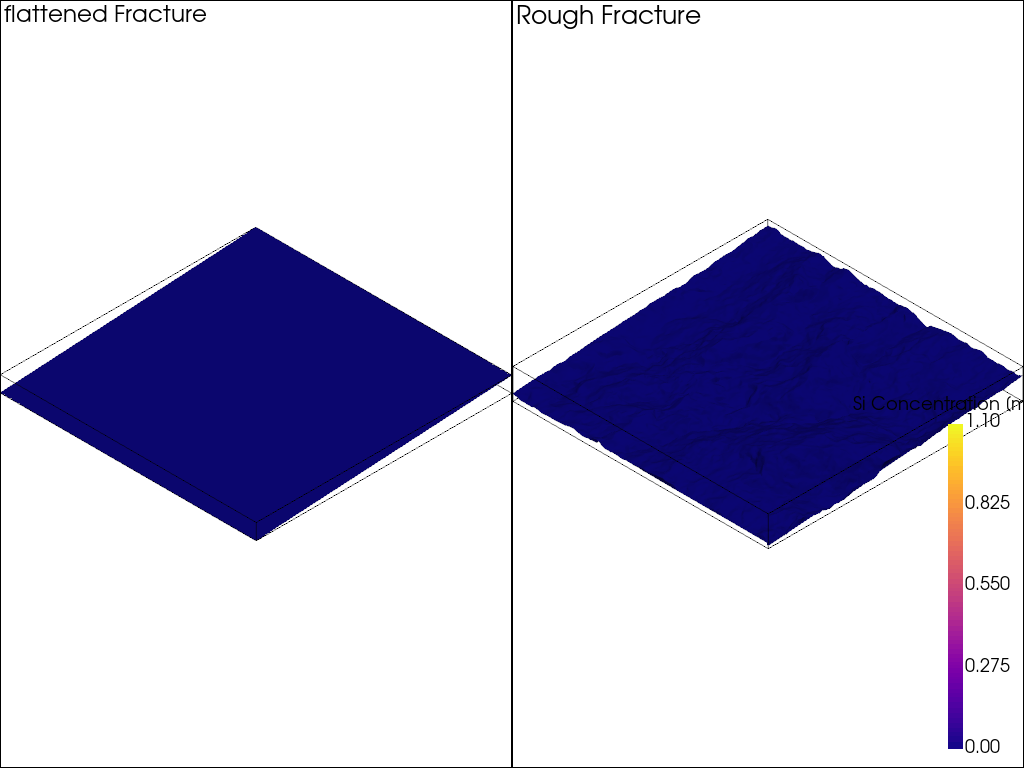

In [20]:
flattened_prefix = user_parameters_flattened["prefix"]
rough_prefix = user_parameters_rough["prefix"]


flattened_series = ot.MeshSeries(f"{flattened_results_dir}/{flattened_prefix}.pvd")
rough_series = ot.MeshSeries(f"{rough_results_dir}/{rough_prefix}.pvd")

frame_paths = []
n_frames = min(len(flattened_series), len(rough_series))
frame_dir = Path(out_dir) / "frames"
frame_dir.mkdir(parents=True, exist_ok=True)

for i in tqdm(range(n_frames), desc="Rendering Si concentration frames"):
    flattened_mesh = flattened_series[i]
    rough_mesh = rough_series[i]

    plotter = pv.Plotter(off_screen=True, shape=(1, 2), border=True)

    # ─── Flat Fracture View ───────────────────────────────────────────────
    plotter.subplot(0, 0)
    plotter.add_text("flattened Fracture", font_size=12)
    plotter.add_mesh(
        flattened_mesh,
        scalars="Si",
        cmap="plasma",
        show_edges=False,
        opacity=1.0,
        clim=(0, 1.1),
        show_scalar_bar=False,
    )
    plotter.add_mesh(flattened_mesh.outline(), color="black", line_width=1)
    plotter.enable_parallel_projection()
    plotter.view_isometric()

    # ─── Rough Fracture View ──────────────────────────────────────────────
    plotter.subplot(0, 1)
    plotter.add_text("Rough Fracture", font_size=12)
    scalar_bar_args = {
        "title": "Si Concentration [mol/m³]",
        "vertical": True,
        "position_x": 0.85,
    }
    plotter.add_mesh(
        rough_mesh,
        scalars="Si",
        cmap="plasma",
        show_edges=False,
        opacity=1.0,
        clim=(0, 1.1),
        scalar_bar_args=scalar_bar_args,
        show_scalar_bar=True,
    )
    plotter.add_mesh(rough_mesh.outline(), color="black", line_width=1)
    plotter.enable_parallel_projection()
    plotter.view_isometric()

    frame_file = frame_dir / f"frame_Si_comparison_{i:04d}.png"
    plotter.screenshot(str(frame_file))
    plotter.close()
    frame_paths.append(frame_file)

gif_path = frame_dir / "Si_concentration_comparison.gif"
iio.imwrite(gif_path, [iio.imread(f) for f in frame_paths], duration=1/5)
Image(filename=str(gif_path))


In [ ]:
flattened_prefix = user_parameters_flattened["prefix"]
rough_prefix = user_parameters_rough["prefix"]

flattened_series = ot.MeshSeries(f"{flattened_results_dir}/{flattened_prefix}.pvd")
rough_series = ot.MeshSeries(f"{rough_results_dir}/{rough_prefix}.pvd")

frame_dir = Path(out_dir) / "frames"
frame_dir.mkdir(parents=True, exist_ok=True)

frame_paths = []
scalar_bar_args = {
    "title": "log₁₀(Darcy Velocity) [m/s]",
    "title_font_size": 16,
    "label_font_size": 12,
    "shadow": True,
    "n_labels": 5,
    "italic": False,
    "fmt": "%.1f",
    "font_family": "arial",
}

def log_mag(mesh):
    v = np.linalg.norm(mesh["darcy_velocity"], axis=1)
    v[v <= 0] = 1e-12
    return np.log10(v)

if len(flattened_series) == 0 or len(rough_series) == 0:
    raise ValueError("MeshSeries is empty. Check .pvd paths or file contents.")

all_mags = [log_mag(m) for m in flattened_series] + [log_mag(m) for m in rough_series]
global_min = min(m.min() for m in all_mags)
global_max = max(m.max() for m in all_mags)

n_frames = min(len(flattened_series), len(rough_series))
for i in tqdm(range(n_frames), desc="Rendering combined frames"):
    meshes = [rough_series[i], flattened_series[i]]
    titles = ["Rough Fracture", "Flat/Inclined Fracture"]

    for mesh in meshes:
        mag = np.linalg.norm(mesh["darcy_velocity"], axis=1)
        mag[mag <= 0] = 1e-12
        log = np.log10(mag)
        mesh["darcy_velocity_magnitude"] = mag
        mesh["log_darcy_velocity_magnitude"] = log
        mesh.set_active_vectors("darcy_velocity")

    plotter = pv.Plotter(shape=(1, 2), window_size=(1600, 800), off_screen=True)
    plotter.set_background("white")

    for j, mesh in enumerate(meshes):
        plotter.subplot(0, j)

        surface = mesh.extract_surface()
        sampled = mesh.sample(surface)
        if "log_darcy_velocity_magnitude" in sampled.array_names:
            surface["log_darcy_velocity_magnitude"] = sampled["log_darcy_velocity_magnitude"]
        else:
            surface["log_darcy_velocity_magnitude"] = np.zeros(surface.n_points)


        # Arrow glyphs
        sparser = surface.decimate_boundary(0.01).interpolate(mesh)
        sparser = sparser.compute_normals(point_normals=True, auto_orient_normals=True)
        sparser.points += 0.0005 * sparser.point_normals
        ids = np.random.choice(sparser.n_points, int(0.8 * sparser.n_points), replace=False)
        subset = sparser.extract_points(ids)

        arrow = pv.Arrow(tip_length=0.3, tip_radius=0.2, shaft_radius=0.1)
        scale = (max(mesh.bounds[1::2]) - min(mesh.bounds[::2])) * 0.01 / mag.max()

        plotter.add_text(titles[j], font_size=14, position="upper_left")
        plotter.add_mesh(
            surface,
            scalars="log_darcy_velocity_magnitude",
            cmap="Blues",
            opacity=0.5,
            show_edges=True,
            clim=(global_min, global_max),
            scalar_bar_args=scalar_bar_args if j == 0 else None,
        )
        if subset.n_points:
            glyphs = subset.glyph(scale="darcy_velocity_magnitude", orient="darcy_velocity", factor=scale, geom=arrow)
            plotter.add_mesh(glyphs, color="black")

        plotter.view_isometric()
        plotter.show_axes()

    frame_path = frame_dir / f"frame_{i:04d}.png"
    img = plotter.screenshot(filename=str(frame_path), return_img=True)
    plotter.close()
    frame_paths.append(frame_path)

gif_path = frame_dir / "darcy_velocity_combined.gif"
frames = [iio.imread(str(p)) for p in frame_paths]
iio.imwrite(gif_path, frames, duration=0.2)
display(Image(filename=str(gif_path)))

Rendering combined frames:   5%|██████▌                                                                                                                                      | 2/43 [00:19<06:34,  9.63s/it]